# Working with data using the Platform
This ML platform is a highly capable and customisable tool for building and training machine learning models. It takes a configuration object with various parameters, such as data location, image size, model type, and loss function, to simplify the process of building and training models. The platform can be used for central and decentralized training and allows access to data without running any training. The platform makes it easy to build and train machine learning models with minimal coding and configuration.

In this notebook, we will focus on how to use the ML platform to access data. With the platform, users can specify various data-related parameters, such as the data path, data version, image size, and data transformation functions to apply.

## Platform basics, working with data
The ML platform is used using a configuration file which specifices the parameters for the platform. The configuration file is a JSON file which contains the parameters for the platform. The configuration file is passed to the platform when it is initialised. 

> For more information about how to use the ML platform and it's configuration, see the [ML platform documentation]

Let's begin with loading the platform.


In [1]:
from src.main import Platform

# Optional: Decentralised shuffle seed

config = {
    "data":{
        "path": "/mnt/ZOD",
        "version":"full",
        "ratio":0.15,
        "img_size": 160,
        "transforms":"[Resize((img_size, img_size))]",
        "shuffle_seed": 42,
        "decentralised_shuffle_seed": 42,
        "dataloader_args": {
            "prefetch_factor": 2,
            "num_workers": 2,
            "batch_size": 32,
        },
        "train_val_id_generator":"balanced_frames"
    },
    "model":{
        "name": "default",
        "args": {
            "num_output":66
        },
        "loss":"MSELoss"
    },
    "central":{
        "train":"true",
        "use_gpu":"true",
        "epochs": 15
    },
    "decentralised":{
        "train": ["swarm", "federated"],
        "global":{
            "n_clients":5,
            "global_rounds":3,
            "client_resources":{
                "num_cpus": 2, 
                "num_gpus": 0.2
            },
            "ray_init_args":{
                "include_dashboard": True,
                "num_cpus": 12,
                "num_gpus": 2
            },
            "swarm_orchestrator": "synchronous_fixed_rounds_fc",
        },
        "client": {
            "epochs": 10
        }
    },
    "note": "ROI Test"
}

platform = Platform(config, data_only=True)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

The platform `DataHandler` object is a custom class that handles the dataloading and contains all the data required for training. The `DataHandler` is accesssed using the `data` attribute of the platform. The `DataHandler` always contains the following attributes: 
- `train` - the training data
- `val` - the validation data
- `test` - the test data

The `train`, `val`, and `test` attributes are `utils.data.DataObject` objects. They are essentially just classes built from dictionaries so that they can be accessed using dot notation. The `DataObject` objects contain various attributes, however, a general structure of the `DataHandler` is as follows:
```
└── DataHandler
    ├── train
    │   ├── central
    │   ├── federated
    │   ├── baseline
    │   └── swarm
    ├── val
    │   ├── central
    │   ├── federated
    │   ├── baseline
    │   └── swarm
    └── test
```

The `central`, `federated`, `baseline`, and `swarm` attributes are added depending on the configuration. For instance, if the configuration specifies that the data should be loaded for central training, then the `train` parameter in the configuration under `central` must be set to `"true"`. 

Example from config:
```json
"central":{
    "train":"true",
    "use_gpu":"true",
    "epochs": 15
}
```

Using the summary notation for initialising the methods in the configuration will also add these objects.

```json
"decentralised":{
    "train": ["swarm", "federated"],
}
 ```

### Traversing the `DataObjects` and their general structure
We will now demonstrate how to access the data in the `DataHandler` and how to use the `DataObjects` to access the data.

In [2]:
# Showing non private attributes of platform.data
{ k:v for k,v in vars(platform.data).items() if not k.startswith('_') }

{'log_dir': PosixPath('/home/alex/swarm-learning-master-thesis/platform/runs/2023-03-19_18:59:47'),
 'central': <src.utils.data.data_handler.DataObject at 0x7fc2b2fa8610>,
 'federated': <src.utils.data.data_handler.DataObject at 0x7fc2ab27b490>,
 'swarm': <src.utils.data.data_handler.DataObject at 0x7fc2ab466fb0>}

These are the attributes of a methods data object. That means that for every enabled method, they will have `train`, `val`, and `test` attributes. These attributes cannot be changed, as per design, however, they can be accessed with their respective properties. For instance, the `_train` attribute can be accessed using the `train` property.

In [3]:
vars(platform.data.federated)

{'_n_clients': 5,
 '_train': <src.utils.data.data_handler.DataObject at 0x7fc2ab540ac0>,
 '_val': <src.utils.data.data_handler.DataObject at 0x7fc2b32a32b0>,
 '_test': <src.utils.data.data_handler.DataObject at 0x7fc2b3723190>}

Here we access the train attribute of the federated data object. For decentralised methods, the data object will contain three attributes: `datasets`, `dataloaders` and `_loader_args`. `datasets` and `dataloaders`, note how they are in plural. Since often in decentralised learning, we have multiple clients, they each require their own dataset. Thus, `datasets` contains a list of PyTorch subsets of the main dataset. `dataloaders` is a method property and generates the datalaoders once accessed. It contains a list of PyTorch dataloaders for each of the subsets. `_loader_args` contains the arguments used to initialise the dataloaders. 

In [4]:
vars(platform.data.federated.train)

{'_datasets': [<torch.utils.data.dataset.Subset at 0x7fc2ab52c790>,
 '_loader_args': {'prefetch_factor': 2, 'num_workers': 2, 'batch_size': 32}}

In [5]:
# Accessing one of the PyTorch Dataloaders
platform.data.federated.train.dataloaders[0]

For the centralised method, the data object will contain the same attributes, however, they will not be in plural. This is because the centralised method only has one dataset and dataloader. 

In [6]:
platform.data.central.train.dataloader

### A quick note on the `DataObject` class and DataLoaders
Like previously mentioned, the `DataLoader` class instances are created upon accessing the attribute. This is in order to save memory when initialising the `DataHandler` part of the platform. If you access the `dataloader` or `dataloaders` attributes without explicitely first creating the dataloaders, you will get a warning. Again, this is because the dataloaders are not created until they are accessed. This is completely OK, and you can ignore the warning. The most important part is that you close or `unmount` the dataloaders when you are done with them. Since the platform is at the top level of the code, the data loader instances will not be garbage collected until the platform is garbage collected.

Thus, you can unmount the dataloaders using `unmount_dataloader` or `unmount_dataloaders` methods. These methods are available in the method `DataObject` classes.

An example of this is how we do it in main.py through a proxy method that accesses the `DataObject` class and calls the `unmount_dataloader(s)` method.
    
```python
if "central" in self.methods:
    run_centralised(**self.training_args("central"))
    self.unmount_dataloaders("central")
```

## Playing with transforms
Here we provide an example of how to work with transforms and the platform. We have created an instance of the platform above with the `data_only` parameter set to `True`. This means that the platform will create the necessary data as per the full configuration, but will not run any of training methods such as central, swarm, etc. This is useful for testing and debugging the dataset.

### Developing a custom transform or working with transforms
We will be using the platform to test and debug our custom or PyTorch transforms.

We access the dataset and its transforms and then apply our changes for testing and debugging. In the below example we create our custom transform and then apply it to the dataset. Default pytorch transforms can be added directly to the platform configuration, but custom transforms must be added to the source code before usage in the config.

For more information on how to use the config. Please see the [config documentation example]

Final Parameters for config: CustomCrop(800, 500, 800, 2840)
Image size after crop: (800, 2840)


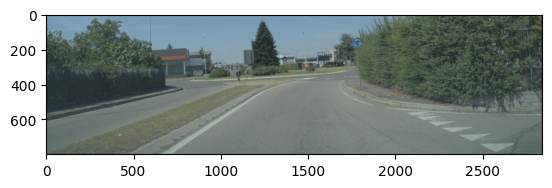

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import *
from torchvision.transforms.functional import crop

# Our custom crop function
class CustomCrop():
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.height = height
        self.width = width

    def __call__(self, img):
        return crop(img, self.top, self.left, self.height, self.width)

# Get our dataset from the platform
dataset = platform.data.train.dataset

# MODIFY HERE, these are the parameters to change our crop
indent_width = 500
indent_top = 800
height = 800

# Print our parameters for the config
print("Final Parameters for config: CustomCrop({}, {}, {}, {})".format(indent_top, indent_width, height, 3840-indent_width*2))
print("Image size after crop: {}".format((height, 3840-indent_width*2)))
      
# Define our transforms
dataset.transforms.transforms = [ToTensor(), CustomCrop(indent_top, indent_width, height, 3840-indent_width*2)]

# Plot the image
image, label = dataset[100]
image = np.transpose(image.int().numpy(), (1, 2, 0)) # swap the axes so that RGB come last
plt.imshow(image)
plt.show()

### Running the platform with our custom transform
We add our custom transform to `data/extensions/custom_transform.py` and then add it to the platform config. We can now run the platform with our custom transform.

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

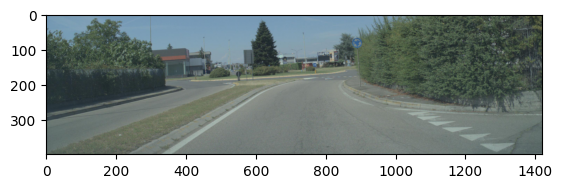

In [8]:
transforms = "[CustomCrop(800, 500, 800, 2840), Resize((400, 1420))]"

# we need to change the img_size parameter for the default model to resize the last fully connected layer
img_size = [400, 1420]

# set the new transforms and img_size
config["data"]["transforms"] = transforms
config["data"]["img_size"] = img_size

# re-initialise the platform
platform = Platform(config, data_only=True)

# Get our dataset from the platform
dataset = platform.data.train.dataset

# Plot the image
image, label = dataset[100]
image = np.transpose(image.int().numpy(), (1, 2, 0)) # swap the axes so that RGB come last
plt.imshow(image)
plt.show()

## Building a custom dataset
The ML platform is built around Zenseact Open Dataset, specifically it is built to serve `ZodFrames`. We provide a basic API in the configuration file where you can specify a method to use to generate the dataset. These custom and default methods must return two list of frame ids, train and validation.


```python
def custom_dataset() -> Tuple[List[str], List[str]]:
    train: List[str] = []
    val: List[str] = []
    return train, val
```

The custom dataset method must be added to the `data/datasets.py` file. The method must be added to the `DATASETS` dictionary. The key is the name of the method and the value is the method itself. The method must return a tuple of two lists of frame ids, train and validation. 

Custom dataset methods must be added to `utils.data.extensions.custom_datasets.py`. They can then be references from the config using the function name.
    
```json
"data":{
    "train_val_id_generator":"balanced_frames"
}
```

### A Limitation of the custom dataset method
Currently, the custom dataset methods run with limited scope and they are not able to access the platform. Thus, the return data must be generated entierly within the method. 

HOWEVER, it is possible to pass arguments to the custom dataset method. These arguments can be passed through the config and the arguments can be local variables in the scope of the platform. However, this is not recommended unless you know what you are doing.

## Data shuffling and seeds
The config has two parameters for dataset shuffling and reproduction.
- `shuffle_seed`: This is the seed used to shuffle the full dataset.
- `decentralised_shuffle_seed`: This is the seed used when splitting the train, val sets into n partitions for n clients. This is only used for decentralised methods.